

# Importing libraries


In [1]:
import pandas as pd
import numpy as np
# from google.colab import drive
# drive.mount('/content/drive')
import re
!pip install -q wordcloud
import wordcloud

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# nltk.download('wordnet')
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger') 
# nltk.download('omw-1.4')
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from IPython.core.display import Path
from gensim.scripts.glove2word2vec import glove2word2vec
import torch
import torch.nn as nn
from torchvision import datasets 
from torchvision.transforms import ToTensor
import torch.nn.functional as F 
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import random
import os
os.environ['PYTHONHASHSEED'] = str(69)
from sklearn.metrics import classification_report, RocCurveDisplay, roc_curve, auc
from sklearn.metrics import f1_score as skf1
from torchmetrics.functional import f1_score
from torchmetrics import ConfusionMatrix

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bgane\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
c:\Users\bgane\anaconda3\envs\jupyter\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def randreset(s):  #making sure each run will yield consistent results
	random.seed(s)
	np.random.seed(s)
	torch.manual_seed(s)
	torch.backends.cudnn.deterministic = True
	torch.backends.cudnn.benchmark = False
	torch.cuda.manual_seed_all(s)
	os.environ['PYTHONHASHSEED'] = str(s)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [7]:
path = 'imdb-reviews.csv'

df = pd.read_csv(path,  sep='\t', lineterminator='\n')

In [8]:
df['review'] = df['review'].apply(lambda r: re.sub(r'\'', '', r))   #removing apostrophes so don't becomes dont
df['review'] = [r.lower() for r in df['review'] ]   #making everything lowercase
df['review'] = df['review'].apply(lambda r: re.sub(r'<br /><br />', ' ', r))  #removing this wierd sequence found in some reviews
df['review'] = df['review'].apply(lambda r: re.sub(r'[^a-z]', ' ', r))   #only keeping letters

rem = stopwords.words('english')
df['review'] = df['review'].apply(lambda r: ' '.join([word for word in r.split() if word not in rem]))

In [9]:
def vectorize(df, w2v):
	X = list()
	Y = list()
	# Scored are either positive or negative
	Scores = list(df['rating'].apply(lambda r: 1 if r > 5 else 0))

	for (i, review) in enumerate(df["review"].values):
		wvectors = list()
		for word in review.split(" "):
			if word in w2v.keys(): # Keeping only words in the vocabulary and using theur value
				wvectors.append(list(w2v[word]))
		if len(wvectors) > 0:
			X.append(np.mean(wvectors, axis=0)) #we keep the mean 
			Y.append(Scores[i])
	return (X,Y)

In [8]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove*.zip

In [13]:
w2v = {}

with open('glove.6B.300d.txt', encoding="utf8") as fp:
	for lines in fp:
		varray = lines.split(" ")
		w2v[varray[0]] = np.asarray(varray[1:], dtype='float32')

(X, Y) = vectorize(df, w2v)


# CREATING SETS

In [14]:
randreset(666)


Xtrain, X1 , Ytrain, Y1 = train_test_split(X, Y, test_size=0.2, random_state=69)
Xval, Xtest , Yval, Ytest = train_test_split(X1, Y1, test_size=0.5, random_state=69)


Xt = torch.tensor(Xtrain, dtype=torch.float, device=device)
Yt = torch.tensor(Ytrain, device=device)
print(Xt.shape, Yt.shape)

Xv = torch.tensor(Xval, dtype=torch.float, device=device)
Yv = torch.tensor(Yval, device=device)
print(Xv.shape, Yv.shape)

XT = torch.tensor(Xtest, dtype=torch.float, device=device)
YT = torch.tensor(Ytest, device=device)
print(Xv.shape, Yv.shape)

TrainDataset = torch.utils.data.TensorDataset(Xt, Yt)
TrainDataloader = torch.utils.data.DataLoader(TrainDataset, batch_size=6001,shuffle=True)

C:\Users\bgane\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:233.)
  


torch.Size([36006, 300]) torch.Size([36006])
torch.Size([4501, 300]) torch.Size([4501])
torch.Size([4501, 300]) torch.Size([4501])


# MODEL CREATION


In [15]:
class RNN(nn.Module):
    def __init__(self, cell_type,input_size, hidden_size, num_layers, drop, device, output_size, attention, num_heads, skip=False):
        super(RNN, self).__init__()
        
        cells = {
        "LSTM"    : nn.LSTM,
        "GRU"     : nn.GRU}
        
        self.cell_type = cell_type
        self.attention = attention
        self.hidden_size = hidden_size
        self.num_layers=num_layers
        self.skip= skip
        self.dropout = nn.Dropout(drop)
        if skip:
            self.rnn = nn.ModuleList()
            self.rnn.append(cells[cell_type](input_size=input_size, hidden_size=hidden_size, num_layers=1, batch_first=True, bidirectional=True, device=device))
            for i in range(num_layers-1):
                self.rnn.append(cells[cell_type](input_size=hidden_size*2, hidden_size=hidden_size, num_layers=1, batch_first=True,  bidirectional=True, device=device))
        else:
            self.rnn = cells[cell_type](input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=drop, bidirectional=True, device=device)
        
#         Attention
        if self.attention:
            self.Q = nn.Linear(hidden_size*2,hidden_size*2, bias=False, device=device)
            self.K = nn.Linear(hidden_size*2,hidden_size*2, bias=False, device=device)
            self.V = nn.Linear(hidden_size*2,hidden_size*2, bias=False, device=device)
            self.att = nn.MultiheadAttention(self.hidden_size*2, num_heads=num_heads ,batch_first=True, device=device)

        
        self.out = nn.Linear(2*hidden_size, output_size, device=device)
        
    def forward(self, x):
        if self.skip:
            if self.cell_type == 'LSTM':
                r_out, (h_n, h_c) = self.rnn[0](x) 
            else:
                r_out, h_n = self.rnn[0](x)
                
            for i in range(self.num_layers-1):
                prev = r_out
                r_out = self.dropout(r_out)
                if self.cell_type == 'LSTM':
                    r_out, (h_n, h_c) = self.rnn[i+1](r_out) 
                else:
                    r_out, h_n = self.rnn[i+1](r_out)
                r_out = r_out + prev
        else:
            if self.cell_type == 'LSTM':
                r_out, (h_n, h_c) = self.rnn(x) 
            else:
                r_out, h_n = self.rnn(x)
                
        if self.attention:
            Q = self.Q(r_out)
            K = self.K(r_out)
            V = self.V(r_out)
            att, _ = self.att(Q, K, V)
            out = att + r_out 
        else:
            out = r_out
        return self.out(out) 
        
        
        

In [16]:
def train(model, epochs, dataloader, learningrate, Xval, Yval, prinntTF, clip):
    lastf1 = None
    lastmodel = None
    lossfunction = nn.CrossEntropyLoss()
    optim = torch.optim.Adam(model.parameters(), lr=learningrate)
    for ep in range(epochs):
        model.train()
        for batch, (X,Y) in enumerate(dataloader):
            optim.zero_grad()
            X = X.to(device)
            Y = Y.to(device)
            Ypred = model(X)
            l = lossfunction(Ypred, Y)
            l.backward()
            
            nn.utils.clip_grad_norm_(model.parameters(), clip)
            
            optim.step()
        with torch.no_grad():
            model.eval()
            _, Vpred = torch.max(model(Xval), 1)
            f1 = f1_score(Vpred.cpu(), Yval.cpu(), average="weighted", num_classes=2)
            if prinntTF:
                print(f"for epoch = {ep} we got loss = {l.item()} and f1 score with val set = {f1}")
            if lastf1 is None:
                lastf1 = f1 
                lastmodel = model
            else:
                if lastf1 > f1:
                    return lastmodel
                else:
                    lastf1 = f1
                    lastmodel = model

    return model

def test(model, Xtest, Ytest):
    with torch.no_grad():
        model.eval()
        _, Ypred = torch.max(model(Xtest), 1)
        Ypred = Ypred.cpu()
        Ytest = Ytest.cpu()
        print(classification_report(Ytest, Ypred))
        return f1_score(Ypred, Ytest,  average="weighted", num_classes=2)

# HYPER PARAMETER TESTING

In [35]:
randreset(666)
model = RNN("GRU",  Xt.shape[1], 21,3,0.325, device, 2,False, 7, False)
model = train(model,50, TrainDataloader ,0.002, Xv, Yv, True, 0.55)
test(model, XT, YT)

for epoch = 0 we got loss = 0.6878880262374878 and f1 score with val set = 0.3777375817298889
for epoch = 1 we got loss = 0.6733901500701904 and f1 score with val set = 0.6399451494216919
for epoch = 2 we got loss = 0.6433064937591553 and f1 score with val set = 0.6524248123168945
for epoch = 3 we got loss = 0.6006518602371216 and f1 score with val set = 0.6824333667755127
for epoch = 4 we got loss = 0.5647004842758179 and f1 score with val set = 0.738653302192688
for epoch = 5 we got loss = 0.5034204721450806 and f1 score with val set = 0.7816058397293091
for epoch = 6 we got loss = 0.46813398599624634 and f1 score with val set = 0.7951647639274597
for epoch = 7 we got loss = 0.4235423505306244 and f1 score with val set = 0.8087131977081299
for epoch = 8 we got loss = 0.4219709038734436 and f1 score with val set = 0.8164901733398438
for epoch = 9 we got loss = 0.40314823389053345 and f1 score with val set = 0.8195844888687134
for epoch = 10 we got loss = 0.3761737048625946 and f1 scor

tensor(0.8285)

In [61]:
randreset(666)
model = RNN("GRU",  Xt.shape[1], 2,2,0.1, device, 2,True, 1)
model = train(model,20, TrainDataloader ,0.02, Xv, Yv, True, 0.5)
test(model, XT, YT)

for epoch = 0 we got loss = 0.6822035312652588 and f1 score with val set = 0.6409139633178711
for epoch = 1 we got loss = 0.6329686641693115 and f1 score with val set = 0.6860765218734741
for epoch = 2 we got loss = 0.5706411600112915 and f1 score with val set = 0.7311735153198242
for epoch = 3 we got loss = 0.5029119253158569 and f1 score with val set = 0.7698549032211304
for epoch = 4 we got loss = 0.47100630402565 and f1 score with val set = 0.7945398092269897
for epoch = 5 we got loss = 0.4298272430896759 and f1 score with val set = 0.8089337348937988
for epoch = 6 we got loss = 0.41953566670417786 and f1 score with val set = 0.8158687353134155
for epoch = 7 we got loss = 0.38646599650382996 and f1 score with val set = 0.8177704811096191
for epoch = 8 we got loss = 0.40217849612236023 and f1 score with val set = 0.8224110007286072
for epoch = 9 we got loss = 0.3903845548629761 and f1 score with val set = 0.8246766328811646
for epoch = 10 we got loss = 0.3628605902194977 and f1 scor

tensor(0.8210)

In [15]:
randreset(666)
model = RNN("GRU", Xt.shape[1], 128, 2,0.2, device, 2,False, 8)
model = train(model,50, TrainDataloader ,0.001, Xv, Yv, True, 0.5)
test(model, XT, YT)

for epoch = 0 we got loss = 0.6955733895301819 and f1 score with val set = 0.34039244055747986
for epoch = 1 we got loss = 0.6820964217185974 and f1 score with val set = 0.6156010627746582
for epoch = 2 we got loss = 0.6544535160064697 and f1 score with val set = 0.7133738994598389
for epoch = 3 we got loss = 0.6018743515014648 and f1 score with val set = 0.7186670303344727
for epoch = 4 we got loss = 0.5371030569076538 and f1 score with val set = 0.7536159753799438
for epoch = 5 we got loss = 0.48373943567276 and f1 score with val set = 0.7804851531982422
for epoch = 6 we got loss = 0.4516068696975708 and f1 score with val set = 0.7993381023406982
for epoch = 7 we got loss = 0.41170042753219604 and f1 score with val set = 0.8108780384063721
for epoch = 8 we got loss = 0.4101329743862152 and f1 score with val set = 0.8233789205551147
for epoch = 9 we got loss = 0.3999020457267761 and f1 score with val set = 0.8251529932022095
for epoch = 10 we got loss = 0.36890900135040283 and f1 scor

tensor(0.8256)

In [42]:
# %pip install optuna
import optuna

def objective(trial):
    hidden_size =  trial.suggest_int('hidden_size', 2,256)
    num_layers = trial.suggest_int('num_layers', 2,12)
    cell_type = trial.suggest_categorical('cell_type', ['LSTM', 'GRU'])
    dropout = trial.suggest_float('dropout', 0.1, 0.6, step=0.025)
    lr = trial.suggest_float('lr', 0.001, 0.9, step=0.001)
    clip =  trial.suggest_float('clip', 0.1, 0.7, step=0.025)
    skip = trial.suggest_categorical('skip', [True, False])
    
    
    randreset(666)
    model=RNN(cell_type=cell_type, input_size=Xt.shape[1], hidden_size=hidden_size, num_layers=num_layers, drop=dropout, device=device, output_size=2, attention=False, num_heads=1, skip=skip)
    model = train(model=model, epochs=50, dataloader=TrainDataloader, learningrate=lr, Xval=Xv, Yval=Yv, prinntTF=False, clip=clip)
    return test(model, XT, YT)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=5000)
    
    

[I 2022-12-22 11:59:42,001] A new study created in memory with name: no-name-f478e390-92c4-4c4b-b7cf-8f3e6820511e
[I 2022-12-22 11:59:48,189] Trial 0 finished with value: 0.3277938663959503 and parameters: {'hidden_size': 120, 'num_layers': 8, 'cell_type': 'GRU', 'dropout': 0.55, 'lr': 0.581, 'clip': 0.375, 'skip': True}. Best is trial 0 with value: 0.3277938663959503.
[I 2022-12-22 11:59:57,574] Trial 1 finished with value: 0.33890238404273987 and parameters: {'hidden_size': 15, 'num_layers': 11, 'cell_type': 'GRU', 'dropout': 0.375, 'lr': 0.78, 'clip': 0.475, 'skip': True}. Best is trial 1 with value: 0.33890238404273987.
[I 2022-12-22 12:00:14,787] Trial 2 finished with value: 0.3351476788520813 and parameters: {'hidden_size': 43, 'num_layers': 7, 'cell_type': 'LSTM', 'dropout': 0.275, 'lr': 0.665, 'clip': 0.65, 'skip': True}. Best is trial 1 with value: 0.33890238404273987.
[I 2022-12-22 12:00:18,375] Trial 3 finished with value: 0.33890238404273987 and parameters: {'hidden_size': 

[32m[I 2022-12-22 17:42:50,177][0m Trial 2701 finished with value: 0.832886815071106 and parameters: {'hidden_size': 16, 'num_layers': 3, 'cell_type': 'LSTM', 'dropout': 0.375, 'lr': 0.042, 'clip': 0.325, 'skip': False}. Best is trial 2701 with value: 0.832886815071106.[0m


In [76]:
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice


In [ ]:
plot_contour(study)


In [ ]:
plot_edf(study)


In [ ]:

plot_optimization_history(study)


In [ ]:
plot_parallel_coordinate(study)


In [ ]:
plot_param_importances(study)


In [ ]:

plot_slice(study)

# PLOTS AND RESULTS

In [50]:
# [32m[I 2022-12-22 17:42:50,177][0m Trial 2701 finished with value: 0.832886815071106 and parameters: {'hidden_size': 16, 'num_layers': 3, 'cell_type': 'LSTM', 'dropout': 0.375, 'lr': 0.042, 'clip': 0.325, 'skip': False}. Best is trial 2701 with value: 0.832886815071106.[0m

randreset(666)
model = RNN("LSTM",  Xt.shape[1], 16,3,0.375, device, 2,False, 7)
model = train(model,50, TrainDataloader ,0.042, Xv, Yv, True, 0.325)
test(model, XT, YT)

for epoch = 0 we got loss = 0.6930248737335205 and f1 score with val set = 0.32632172107696533
for epoch = 1 we got loss = 0.6887859106063843 and f1 score with val set = 0.34039244055747986
for epoch = 2 we got loss = 0.6068342328071594 and f1 score with val set = 0.7398492097854614
for epoch = 3 we got loss = 0.5080610513687134 and f1 score with val set = 0.7811192274093628
for epoch = 4 we got loss = 0.4721395671367645 and f1 score with val set = 0.7948934435844421
for epoch = 5 we got loss = 0.4260786175727844 and f1 score with val set = 0.8008947372436523
for epoch = 6 we got loss = 0.4244437515735626 and f1 score with val set = 0.8232753276824951
for epoch = 7 we got loss = 0.3973046839237213 and f1 score with val set = 0.8267006874084473
for epoch = 8 we got loss = 0.40154266357421875 and f1 score with val set = 0.830923855304718
for epoch = 9 we got loss = 0.3957265615463257 and f1 score with val set = 0.8342480063438416
for epoch = 10 we got loss = 0.375724732875824 and f1 scor

tensor(0.8261)

In [16]:
# [32m[I 2022-12-21 21:34:56,824][0m Trial 140 finished with value: 0.830222487449646 and parameters: {'hidden_size': 21, 'num_layers': 3, 'cell_type': 'GRU', 'dropout': 0.325, 'lr': 0.002, 'clip': 0.55}. Best is trial 140 with value: 0.830222487449646.[0m

randreset(666)
model = RNN("GRU",  Xt.shape[1], 21,3,0.325, device, 2,False, 7)
model = train(model,50, TrainDataloader ,0.002, Xv, Yv, True, 0.55)
test(model, XT, YT)

for epoch = 0 we got loss = 0.6878572702407837 and f1 score with val set = 0.3367669880390167
for epoch = 1 we got loss = 0.6748159527778625 and f1 score with val set = 0.6606339812278748
for epoch = 2 we got loss = 0.643193244934082 and f1 score with val set = 0.6706370711326599
for epoch = 3 we got loss = 0.59930419921875 and f1 score with val set = 0.6955235004425049
for epoch = 4 we got loss = 0.5548759698867798 and f1 score with val set = 0.7383284568786621
for epoch = 5 we got loss = 0.5014206767082214 and f1 score with val set = 0.7828746438026428
for epoch = 6 we got loss = 0.46720200777053833 and f1 score with val set = 0.7970690727233887
for epoch = 7 we got loss = 0.42958757281303406 and f1 score with val set = 0.8117623329162598
for epoch = 8 we got loss = 0.4227931499481201 and f1 score with val set = 0.816913902759552
for epoch = 9 we got loss = 0.40820929408073425 and f1 score with val set = 0.8193044662475586
for epoch = 10 we got loss = 0.3805502653121948 and f1 score 

tensor(0.8266)

In [15]:
# [32m[I 2022-12-21 21:34:56,824][0m Trial 140 finished with value: 0.830222487449646 and parameters: {'hidden_size': 21, 'num_layers': 3, 'cell_type': 'GRU', 'dropout': 0.325, 'lr': 0.002, 'clip': 0.55}. Best is trial 140 with value: 0.830222487449646.[0m

randreset(666)
model = RNN("GRU",  Xt.shape[1], 21,3,0.325, device, 2,True, 7)
model = train(model,50, TrainDataloader ,0.002, Xv, Yv, True, 0.55)
test(model, XT, YT)


for epoch = 0 we got loss = 0.6938670873641968 and f1 score with val set = 0.32632172107696533
for epoch = 1 we got loss = 0.6887758374214172 and f1 score with val set = 0.42788970470428467
for epoch = 2 we got loss = 0.6811063885688782 and f1 score with val set = 0.6278131604194641
for epoch = 3 we got loss = 0.6565708518028259 and f1 score with val set = 0.6605937480926514
for epoch = 4 we got loss = 0.6225779056549072 and f1 score with val set = 0.6804285645484924
for epoch = 5 we got loss = 0.5706347823143005 and f1 score with val set = 0.7352097034454346
for epoch = 6 we got loss = 0.5057080388069153 and f1 score with val set = 0.7858313918113708
for epoch = 7 we got loss = 0.4498014450073242 and f1 score with val set = 0.7973325252532959
for epoch = 8 we got loss = 0.43438535928726196 and f1 score with val set = 0.8131346702575684
for epoch = 9 we got loss = 0.41495391726493835 and f1 score with val set = 0.8182441592216492
for epoch = 10 we got loss = 0.38805854320526123 and f1 

tensor(0.8267)

In [20]:
# [32m[I 2022-12-22 17:42:50,177][0m Trial 2701 finished with value: 0.832886815071106 and parameters: {'hidden_size': 16, 'num_layers': 3, 'cell_type': 'LSTM', 'dropout': 0.375, 'lr': 0.042, 'clip': 0.325, 'skip': False}. Best is trial 2701 with value: 0.832886815071106.[0m

randreset(666)
model = RNN("LSTM",  Xt.shape[1], 16,3,0.375, device, 2,False, 7)
model = train(model,50, TrainDataloader ,0.042, Xv, Yv, True, 0.325)
test(model, XT, YT)

torch.save(model.state_dict(), 'myNN.pt')


for epoch = 0 we got loss = 0.6932142972946167 and f1 score with val set = 0.32632172107696533
for epoch = 1 we got loss = 0.6832873821258545 and f1 score with val set = 0.5675634741783142
for epoch = 2 we got loss = 0.6324926018714905 and f1 score with val set = 0.7326534986495972
for epoch = 3 we got loss = 0.5186166763305664 and f1 score with val set = 0.7848207950592041
for epoch = 4 we got loss = 0.4668842554092407 and f1 score with val set = 0.8102771043777466
for epoch = 5 we got loss = 0.44878003001213074 and f1 score with val set = 0.8151530027389526
for epoch = 6 we got loss = 0.420542448759079 and f1 score with val set = 0.8200112581253052
for epoch = 7 we got loss = 0.3887808918952942 and f1 score with val set = 0.821047306060791
for epoch = 8 we got loss = 0.4042562246322632 and f1 score with val set = 0.8319390416145325
for epoch = 9 we got loss = 0.38532525300979614 and f1 score with val set = 0.8349201679229736
for epoch = 10 we got loss = 0.3720010221004486 and f1 scor

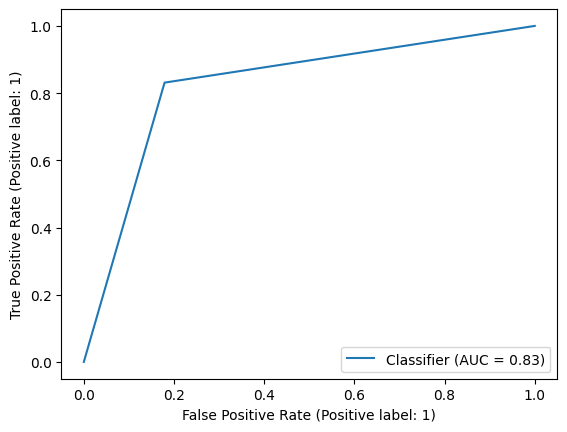

In [67]:
def plotROC(model, Xtest, Ytest):
	with torch.no_grad():
		model.eval()
		_, Ypred = torch.max(model(Xtest), 1)
		Ypred = Ypred.cpu()
		Ytest = Ytest.cpu()
		RocCurveDisplay.from_predictions(Ytest, Ypred)
		plt.show()
plotROC(model, XT, YT)

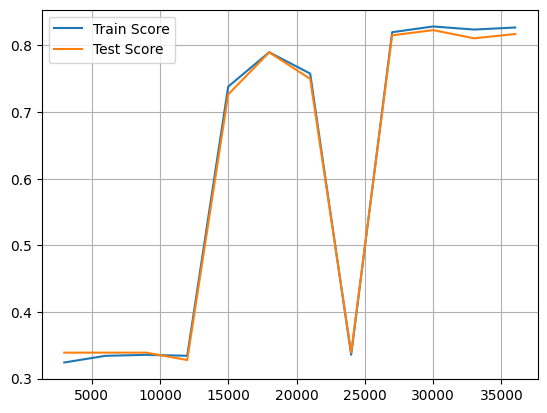

In [69]:
randreset(666)
Xtrain, X1 , Ytrain, Y1 = train_test_split(X, Y, test_size=0.2, random_state=69)
Xval, Xtest , Yval, Ytest = train_test_split(X1, Y1, test_size=0.5, random_state=69)

Xt = torch.tensor(Xtrain, dtype=torch.float, device=device)
Yt = torch.tensor(Ytrain, device=device)

Xv = torch.tensor(Xval, dtype=torch.float, device=device)
Yv = torch.tensor(Yval, device=device)

XT = torch.tensor(Xtest, dtype=torch.float, device=device)
YT = torch.tensor(Ytest, device=device)

Tscores = []
Vscores = []
for size in [3000,6000,9000,12000,15000,18000,21000,24000,27000,30000,33000,36006]:
	TrainDataset = torch.utils.data.TensorDataset(Xt[:size], Yt[:size])
	TrainDataloader = torch.utils.data.DataLoader(TrainDataset, batch_size=6001,shuffle=True)
	randreset(666)
	model = RNN("LSTM",  Xt.shape[1], 16,3,0.375, device, 2,False, 7)
	model = train(model,50, TrainDataloader ,0.042, Xv, Yv, False, 0.325)	
	_, Ptrain = torch.max(model(Xt[:size]), 1)
	Ptrain = Ptrain.cpu()
	Ptraintrue = Yt.cpu()
	_, Ptest = torch.max(model(XT), 1)
	Ptest = Ptest.cpu()
	Ptesttrue = YT.cpu()
	Tscores+= [skf1(Ptraintrue[:size], Ptrain, average="weighted")]
	Vscores += [skf1(Ptesttrue, Ptest, average="weighted")]
	
plt.grid()
plt.plot([3000,6000,9000,12000,15000,18000,21000,24000,27000,30000,33000,36006], Tscores, label="Train Score")
plt.plot([3000,6000,9000,12000,15000,18000,21000,24000,27000,30000,33000,36006], Vscores, label="Test Score")
plt.legend()
plt.show()

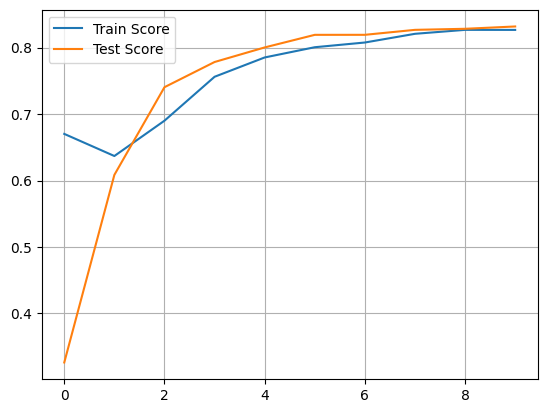

In [74]:
def LC(model, epochs, dataloader, learningrate, Xval, Yval, prinntTF, clip):
    eps = []
    f1train = []
    f1val = []
    lastf1 = None
    lastmodel = None
    lossfunction = nn.CrossEntropyLoss()
    optim = torch.optim.Adam(model.parameters(), lr=learningrate)
    for ep in range(epochs):
        model.train()
        for batch, (X,Y) in enumerate(dataloader):
            optim.zero_grad()
            X = X.to(device)
            Y = Y.to(device)
            Ypred = model(X)
            _, pred = torch.max(Ypred, 1)
            f1tr = f1_score(Y.cpu(), pred.cpu(), average="weighted", num_classes=2)
            l = lossfunction(Ypred, Y)
            l.backward()
            
            nn.utils.clip_grad_norm_(model.parameters(), clip)
            
            optim.step()
        with torch.no_grad():
            model.eval()
            _, Vpred = torch.max(model(Xval), 1)
            f1 = f1_score(Vpred.cpu(), Yval.cpu(), average="weighted", num_classes=2)
            if prinntTF:
                print(f"for epoch = {ep} we got loss = {l.item()} and f1 score with val set = {f1}")
            if lastf1 is None:
                lastf1 = f1 
                lastmodel = model
            else:
                if lastf1 > f1:
                    model = lastmodel 
                    break
                else:
                    lastf1 = f1
        eps.append(ep)
        f1train.append(f1tr)
        f1val.append(f1)
    plt.grid()
    plt.plot(eps, f1train, label="Train Score")
    plt.plot(eps, f1val, label="Test Score")
    plt.legend()
    plt.show()
    return model

randreset(666)
model = RNN("LSTM",  Xt.shape[1], 16,3,0.375, device, 2,False, 7)
model = LC(model,50, TrainDataloader ,0.042, Xv, Yv, False, 0.325)


Old grid search hyper parameter tunning

In [17]:
# def testf(model, Xtest, Ytest, f):
# 	with torch.no_grad():
# 		model.eval()
# 		_, Ypred = torch.max(model(Xtest), 1)
# 		Ypred = Ypred.cpu()
# 		Ytest = Ytest.cpu()
# 		f.write(classification_report(Ytest, Ypred))

In [ ]:
# f = open("out.txt", "w") 
# for hidden_size in [2,4,8,16,32,64,128,256]:
# 	for num_layers in [2,4,6,8,10]:
# 		for cell_type in ['LSTM', 'GRU']:
# 			for clip in [0.2,0.4,0.5,0.7]:
# 				for lr in [0.001,0.002,0.01,0.02,0.1,0.2]:
# 					for dropout in [0.1,0.3,0.5]:
# 						randreset(666)
# 						model=RNN(cell_type=cell_type, input_size=Xt.shape[1], hidden_size=hidden_size, num_layers=num_layers, dropout=dropout, device=device, output_size=2, attention=False, num_heads=1)
# 						model = train(model=model, epochs=50, dataloader=TrainDataloader, learningrate=lr, Xval=Xv, Yval=Yv, prinntTF=False, clip=clip)
# 						f.write(f"for hidden_size = {hidden_size}, num_layers = {num_layers}, cell_type = {cell_type}, clip = {clip}, lr = {lr}, dropout = {dropout}\n")
# 						testf(model, XT, YT, f)
# f.close()

In [ ]:
# f = open("out.txt", "r") #interpreting the results and finding the best combinations
# bestacc = -1
# bestline = list()
# for i in range(4200):	
# 	line1 = f.readline()
# 	line2 = f.readline()
# 	line3 = f.readline()
# 	line4 = f.readline()
# 	line5 = f.readline()
# 	line6 = f.readline()
# 	line7 = f.readline()
# 	line8 = f.readline()
# 	line9 = f.readline()

# 	acc = line7.split()
# 	if float(acc[1]) > bestacc:
# 		bestacc = float(acc[1])
# 		bestline = [line1]
# 	elif float(acc[1]) == bestacc:
# 		bestline.append(line1)
# print(bestacc)
# for l in bestline:
# 	print(l)

# f.close()